require input "X_train_rotate.npy"
"X_test.npy"
"target_train.npy"
"test_id"

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import optimizers
from keras.optimizers import Adam
from keras.applications.vgg19 import VGG19

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
epochs = 200
batch_size = 64
split = 0.9

In [3]:
X_train=np.load('X_train_rotate.npy')
target_train=np.load('target_train.npy')
#X_test=np.load('X_test.npy')
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, train_size=split)
nb_train_samples = len(X_train_cv)
nb_train_samples = len(X_train_cv)
nb_validation_samples = len(X_valid)
X_train.shape

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(4812, 75, 75, 3)

In [4]:
def save_bottlebeck_features():
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    
    bottleneck_features_train = model.predict(X_train_cv)
    np.save('bottleneck_features_train.npy', bottleneck_features_train)

    bottleneck_features_validation = model.predict(X_valid)
    np.save('bottleneck_features_validation.npy', bottleneck_features_validation)
    
    #bottleneck_features_validation = model.predict(X_test)
    #np.save('bottleneck_features_test.npy', bottleneck_features_validation)

In [5]:
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]



In [6]:
mypotim=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
def train_top_model():
    train_data = np.load('bottleneck_features_train.npy')
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=mypotim,
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    model.summary()
    return model
    
    

In [7]:
file_path = 'top_model_weights_path.h5'
callbacks = get_callbacks(filepath=file_path, patience=20)

In [8]:
import os
save_bottlebeck_features()
model = train_top_model()
train_data = np.load('bottleneck_features_train.npy')
validation_data = np.load('bottleneck_features_validation.npy')
    

history = model.fit(train_data, y_train_cv,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, y_valid),
                    callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 1,180,673
Trainable params: 1,180,673
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.load_weights(filepath=file_path)
score = model.evaluate(validation_data, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

482/482 [==============================] - 0s 55us/step
Test loss: 0.342239198843
Test accuracy: 0.848547717842


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


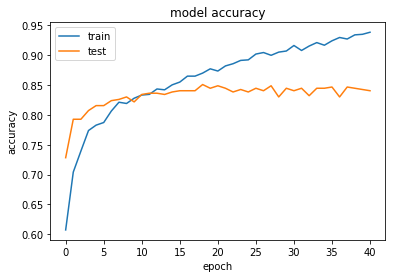

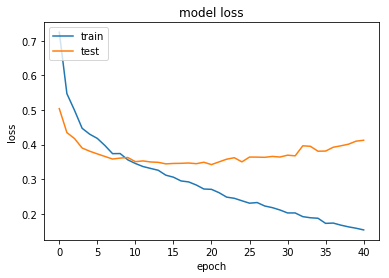

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
X_test = np.load('bottleneck_features_test.npy')
predicted_test=model.predict(X_test,verbose=1)

FileNotFoundError: [Errno 2] No such file or directory: 'bottleneck_features_test.npy'

In [ ]:
import pandas as pd
submission = pd.DataFrame()
test_id=np.load('test_id.npy')
submission['id']=test_id
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('sub.csv', index=False)